In [1]:
import numpy as np
import cv2
import os
import math
import numpy.linalg as linalg
import sys
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.signal
from keras.models import *
import sqlite3
%matplotlib inline 
import glob

import pickle
import keras
import keras.backend as K
from keras.layers import *
from keras.optimizers import *
from keras.models import *

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def GetTransformationParams(img_src_shape, img_dst_shape, K_cam1, K_cam2, z, cam_shift=[0,0,0], debug=False):
    
    # Generate a vector of points on a plane
    P = np.zeros( ( img_src_shape[0]*img_src_shape[1],3 ), dtype=np.float32 )
    i = 0
    for x in range(img_src_shape[1]):
        for y in range(img_src_shape[0]):
            P[i,0] = x
            P[i,1] = y
            P[i,2] = 1
            i+=1

    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    if debug:
        print(P_out.shape)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s
        
        
    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 ) # do we even use it?
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     
    
    KIC = np.matmul(K_cam2, IC)
    
    # Generate homogeneous coordinates
    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))

    # Transform
    out = np.matmul( KIC, np.transpose(P_out_4D))
    out = np.transpose(out)
    out[:,0] = np.divide(out[:,0], out[:,2])
    out[:,1] = np.divide(out[:,1], out[:,2])
    out[:,2] = np.divide(out[:,2], out[:,2])

    p_out = out.astype(np.int64)
    p_in = P.astype(np.int64)
    coords_src = []
    coords_dst = []
    for i in range(0, out.shape[0]):
#        img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        if p_out[i,0] < 0 or p_out[i,1] < 0 or p_in[i,0] < 0 or p_out[i,1] < 0 :
            continue
        if p_out[i,0] >= img_dst_shape[0] or p_out[i,1] > img_dst_shape[1] or p_in[i,0] >= img_src_shape[0] or p_in[i,1] >= img_src_shape[1]:
            continue
        coords_src.append( p_in[i,] )
        coords_dst.append( p_out[i,] )
    
    return np.array(coords_src).astype(np.int64), np.array(coords_dst).astype(np.int64)
#    return P.astype(np.int64), out.astype(np.int64)





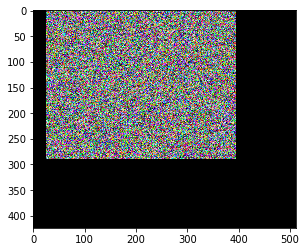

In [26]:
def apply_pixel_transformation(img_in, img_out, p_in, p_out):
    for i in range(0, p_in.shape[0]):
        img_out[  p_out[i,0], p_out[i,1] ,: ] = img_in[ p_in[i,0], p_in[i,1] ,:] 
    
img_out = np.zeros((424,512,3))
apply_pixel_transformation( np.random.uniform(0,1,(1080, 1920,3)) ,
                           img_out,p_in, p_out )

plt.imshow(img_out)
plt.show()

In [23]:
p_in, p_out = GetTransformationParams([1080,1920,3], [424,512,1], K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])

print(p_in.shape)
print(p_out.shape)


(943920, 3)
(943920, 3)


In [3]:
def CameraMatrix(fx, fy, cx, cy):
    K = np.array([ [fx, 0, cx], [0, fy, cy ], [0,0,1] ])
    return K

def TransformCameraOnZPlane(img_col, img_ir, K_cam1, K_cam2, z, cam_shift=[0,0,0], coords_in=None, debug=False):
    
    if coords_in is None:
        # Generate a vector of points on a plane
        P = np.zeros( ( img_col.shape[0]*img_col.shape[1],3 ), dtype=np.float32 )
        i = 0
        for x in range(img_col.shape[1]):
            for y in range(img_col.shape[0]):
                P[i,0] = x
                P[i,1] = y
                P[i,2] = 1
                i+=1
    else:
        P = coords_in

    if debug:
        print('P shape:')
        print(P.shape)
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    if debug:
        print(P_out.shape)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s
        
        
    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 ) # do we even use it?
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     
    
    KIC = np.matmul(K_cam2, IC)
    
    # Generate homogeneous coordinates
    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))
    if debug:
        print(P_out_4D)
        print(P_out_4D.shape)


    if 0:
        P_out_4D = np.array(  [ 0,0,z,1 ], dtype=np.float32)
        P_out_4D = np.reshape( P_out_4D, (1,4) )
        print(P_out_4D.shape)

    # Transform
    out = np.matmul( KIC, np.transpose(P_out_4D))
    if debug:
        print('out shape:')
        print(out.shape)
    out = np.transpose(out)
    print(out.shape)
    out[:,0] = np.divide(out[:,0], out[:,2])
    out[:,1] = np.divide(out[:,1], out[:,2])
    out[:,2] = np.divide(out[:,2], out[:,2])

    # Actual center of IR image 243.892, 208.922
    if debug:
        print('Final=')
        print(out)
    
#    img_ir = np.array(Image.open(image_ir), dtype=np.float32)

    if debug:
        print(img_ir.shape)
        print(P.shape)
        print(out.shape)




    img = np.zeros( (img_ir.shape[0], img_ir.shape[1], 3) )
    for i in range(0, out.shape[0]):
        p_out = out[i,:].astype(np.int64)
        p_in = P[i,:].astype(np.int64)
        try :
            img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        except:
            continue
            #print('Out of bounds')


    if debug:
        plt.imshow(img_ir, cmap='gray')
        plt.show()

        plt.imshow(img_col.astype(np.uint8))
        plt.show()
        plt.imshow(img.astype(np.uint8))
        plt.show()   
        
    return img


def drawConnectedComponents(img):
    out = cv2.connectedComponents(img.astype(np.uint8))
    plt.imshow(out[1])
    plt.show()

    for i,val in enumerate(np.unique(out[1])):
        perc = np.sum(out[1]==val)/np.prod(out[1].shape)
        plt.imshow( np.multiply(out[1], out[1]==val) )
        plt.title('ID: {}, perc: {}%'.format(i,100*perc))
        plt.show()



def TransformCoordinates(P, K_cam1, K_cam2, z, cam_shift=[0,0,0], debug=False):
    
    P = np.array(P, dtype=np.float32)
    if(len(P.shape)==2):
        o = np.ones( (P.shape[0], 1), dtype=np.float32 )
        P = np.hstack((P, o))
    
        print(P)
    
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s


    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 )
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     

    KIC = np.matmul(K_cam2, IC)

    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))


    out = np.matmul( KIC, np.transpose(P_out_4D))
    out = np.transpose(out)
    for i in range(0, out.shape[0]):
        out[i, 0] = out[i,0]/out[i,2]
        out[i, 1] = out[i,1]/out[i,2]
        out[i, 2] = out[i,2]/out[i,2]


    return out[:, 0:2]


# Using: https://threeconstants.wordpress.com/2014/11/09/kinect-v2-depth-camera-calibration/
#Focal Length (x,y) :   391.096, 463.098
#Principle Point (x,y): 243.892, 208.922
K_IR = np.array([ [391.096, 0, 243.892], [0, 463.098, 208.922 ], [0,0,1] ])
print('K IR:')
print(K_IR)


# Color properties from: https://github.com/OpenKinect/libfreenect2/issues/41
#fx 1060.707250708333, cx 956.354471815484
#fy 1058.608326305465, cy 518.9784429882449
K_Color = np.array([[ 1060.707250708333, 0, 956.354471815484 ], [0,1058.608326305465, 518.9784429882449 ], [0,0,1] ])


K_IR = CameraMatrix(351.096, 363.098,243.892,208.922)


P = [ [0,0], [1920, 1080], [600,600] ]
TransformCoordinates(P, K_Color, K_IR, 2500, cam_shift=[26,-35,0], debug=False)




K IR:
[[391.096   0.    243.892]
 [  0.    463.098 208.922]
 [  0.      0.      1.   ]]
[[0.00e+00 0.00e+00 1.00e+00]
 [1.92e+03 1.08e+03 1.00e+00]
 [6.00e+02 6.00e+02 1.00e+00]]


array([[-69.01164486,  25.8313046 ],
       [566.51179438, 396.2665546 ],
       [129.5894299 , 231.62866571]])

In [4]:
# img is the depth image
def get_normals(img):
    normals = np.zeros(( img.shape[0], img.shape[1], 3 ))

    r = 5
    for x in range(r, img.shape[1]-r):
        for y in range(r,img.shape[0]-r):
            a = np.array([ x-r, y, img[y,x-r] ])
            b = np.array([ x, y-r, img[y-r,x] ])
            c = np.array([ x, y, img[y,x] ])
            z = np.cross( a-c, b-c )
            z = np.divide(z, np.linalg.norm(z))
            normals[y,x,:] = z

    
    for i in range(0,3):        
        plt.figure(figsize=(20,10))
        plt.imshow(normals[:,:,i])
        plt.title('Normals channel : {}'.format(i))
        plt.show()
    return normals


def filter_masks( instance_mask_img, numpix_th=100 ):
    l = cv2.cvtColor(instance_mask_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    j = 1
    output_mask = np.zeros(( instance_mask_img.shape[0], instance_mask_img.shape[1] ))
    for val in np.unique(l):
        numpix = np.sum(l==val)
        if numpix > numpix_th and val > 0:
            output_mask = np.multiply(output_mask, output_mask>0) + j*np.multiply(l==val, output_mask==0)
            j +=1
    return output_mask

def load_and_transform_for_prefix(prefix):
    conn = sqlite3.connect('E:/Captures/2017_03_07_17_16_25/Files.sqlite')
    c = conn.execute('SELECT * FROM generalFiles WHERE filename LIKE \'%{}%\''.format(prefix))
    finfo = c.fetchone()[0]
    conn.close()

    finfo = finfo.replace('\\', '/')
    fpath_depth = os.path.join('E:/Captures/2017_03_07_17_16_25','Depth', finfo + '.png')
    fpath_color = os.path.join('E:/Captures/2017_03_07_17_16_25','Color', finfo + '.jpg')
    fpath_ir = os.path.join('E:/Captures/2017_03_07_17_16_25','Infrared', finfo + '.jpg')

    print('Loading images...')
    img_ir = np.array(Image.open(fpath_ir), dtype=np.float32)
    img_col = np.array(Image.open(fpath_color), dtype=np.float32)
    imgd = np.array(Image.open(fpath_depth), dtype=np.float32)

    print('Transforming...')
    img = TransformCameraOnZPlane(img_col, img_ir, K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
    img_col_trans = img


    ret = dict()
    ret['color_orig'] = img_col
    ret['ir'] = img_ir
    ret['color_trans'] = img
    ret['depth'] = imgd

    if 0:
        plt.figure(figsize=(20,10))
        plt.imshow(img_col.astype(np.uint8))
        plt.title('Original color image')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(img_ir)
        plt.title('IR Image')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(img.astype(np.uint8))
        plt.title('Color image transformed')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(imgd, cmap='gray')
        plt.title('Depth image')
        plt.show()
    return ret



def normalize(x):
    """
    Normalize input to be zero mean and divide it by its global maximum value. 
    """

    x = x - np.min(x, keepdims = False)
    x = x/(np.max(x, keepdims = False) + 1e-10)
    return np.copy(x)

def remove_random_labels(intmask, keep_prob=0.7):
    out = np.copy(intmask)*0
    vals = np.unique(intmask)[1:] # skip the zero
    tokeep = np.where(np.random.uniform(0,1,(vals.shape[0]))<keep_prob)[0]
    j=1
    for val in vals[tokeep]:
        out = np.multiply(out, out>0) + j*np.multiply( intmask==val, out==0 )
        j = j+1
    return out
    
    

In [30]:
with open('floorplane.pickle', 'rb') as file:
    floorplane = pickle.load(file)
ir_mask = np.array(Image.open('ir_mask.png'))>0    

In [ ]:


    

plt.imshow(floorplane)
plt.show()

examples = []
# GET THE MASK FILES
mask_fpaths = glob.glob('D:/Datasets/PigMasks_2017_03_07/*png')
for i,mask_fpath in enumerate(mask_fpaths):
    clear_output()
    prefix = os.path.basename(mask_fpath)[0:-9]
    print('Example {} / {} - {}'.format(i, len(mask_fpaths), prefix))
    instance_mask_img = np.array(Image.open(mask_fpath), dtype=np.float32)[:,:,0:3]

    
    data = load_and_transform_for_prefix(prefix)

    instance_mask_img_transformed = TransformCameraOnZPlane(instance_mask_img, data['ir'], K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
    plt.imshow(instance_mask_img_transformed)
    plt.show()
    
    data['instance_mask_trans'] = instance_mask_img_transformed
    data['instance_mask'] = instance_mask_img
    data['heightmap'] = floorplane-data['depth']
    data['heightmap_masked'] = np.multiply(data['heightmap'], ir_mask)
    data['heightmap_masked'] = np.multiply(data['heightmap_masked'], data['heightmap_masked']>50)
    data['heightmap_masked'] = np.multiply(data['heightmap_masked'], data['heightmap_masked']<600)
    data['normals'] = get_normals(data['heightmap_masked'])
    data['integer_mask'] = filter_masks(instance_mask_img_transformed)
    
    out_fname = prefix + '.pickle'
    with open(out_fname, 'wb') as file:
        print('Saving file...  {}'.format(out_fname))
        pickle.dump(data, file)
    
    examples.append(data)

clear_output()
print('DONE!')
    

Example 3 / 23 - 2017_03_09_00_00_00_196
Loading images...
Transforming...
(2073600, 3)
(2073600, 3)


In [6]:
# LOAD PRE-GENERATED EXAMPLE!
example_fpaths = glob.glob('2017*.pickle')
examples = []
for example_fpath in example_fpaths:
    with open(example_fpath, 'rb') as file:
        example = pickle.load(file)
        examples.append(example)

print(len(examples))

23


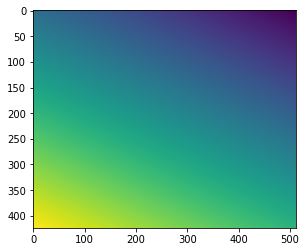

In [32]:
# HERE WE ARE CALCULATING THE FLOOR PLANE

# USe lease squares to extrapolate the floor plan
def get_floor_plane(floor, imgd):
    A = np.concatenate([floor, np.ones((floor.shape[0],1))], 1)
    b = np.array([ imgd[floor[i][1],floor[i][0]] for i in range(0, floor.shape[0])])
    X = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(A), A)), np.transpose(A)), b)
    floorplane = np.copy(imgd)*0
    P = np.zeros(( floorplane.shape[0]*floorplane.shape[1] ,3))
    i=0
    for x in range(0, floorplane.shape[1]):
        for y in range(0, floorplane.shape[0]):
            P[i,:] = [ x,y,1 ]
            i+=1
    P_out = np.dot( P, X )
    i=0
    for x in range(0, floorplane.shape[1]):
        for y in range(0, floorplane.shape[0]):
            floorplane[y,x] = P_out[i]
            i+=1
    return floorplane, X

if 0:
    floor = np.array([ [188,169],[172,243], [87,281],[82,226],[88,108],  [434,108], [442,191]  ,[357,155]  ])
    floorplane, _ = get_floor_plane(floor, imgd)
    with open('floorplane.pickle', 'wb') as file:
        print('Saving the floor plane')
        pickle.dump(floorplane, file)
        
    plt.figure(figsize=(20,10))
    plt.imshow(floorplane-imgd)
    plt.plot( floor[:,0], floor[:,1] )
    for i in range(0, floor.shape[0]):
        plt.text( floor[i,0], floor[i,1], imgd[floor[i][1],floor[i][0]] , color='magenta')
    plt.show()






In [7]:
def discriminative_loss_without_background(y_true, y_pred):
    """
    Custom loss function for pixel embedding (ETH-Zurich)
    Inputs:
    ======
    y_true: tensor -- not actually ground truth embedding. Used to sneak in mask and 
        weight matrices
    y_pred: tensor -- ground truth matrices; created by np.concatenate((mask, weight))
    Outputs:
    =======
    cost = variance term + distance term (no regularization term because embedding sphere)
    """
    
    # hyperparameters
    delta_var = 0.5
    delta_d = 1.5

    # read output dimensions
    embedding_dim = K.int_shape(y_pred)[-1]

    # unpack weight and mask
    w = y_true[:, :, :, 0]
    mask = y_true[:, :, :, 1]

    # get number of pixels and clusters
    num_cluster = tf.reduce_max(mask)
    num_cluster = tf.cast(num_cluster, tf.int32)

    # one-hot encoding for mask
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    mask_one_hot = tf.one_hot(mask, num_cluster)

    # flatten
    y_pred_flat = tf.reshape(y_pred, shape = (-1, embedding_dim))
    mask_one_hot_flat = tf.reshape(mask_one_hot, shape = (-1, num_cluster))
    mask_flat = K.flatten(mask)

    # ignore background pixels
    non_background_idx = tf.greater(mask_flat, -1)
    y_pred_flat = tf.boolean_mask(y_pred_flat, non_background_idx)
    mask_flat = tf.boolean_mask(mask_flat, non_background_idx)
    mask_one_hot_flat = tf.boolean_mask(mask_one_hot_flat, non_background_idx)

    # center count
    center_count = tf.reduce_sum(tf.cast(mask_one_hot_flat, dtype = tf.float32), axis = 0)

    # variance term
    centers = tf.matmul(tf.transpose(y_pred_flat), tf.cast(mask_one_hot_flat, dtype = tf.float32))
    centers = tf.divide(centers, center_count)
    gathered_center = tf.gather(centers, mask_flat, axis = 1)
    gathered_center_count = tf.gather(center_count, mask_flat)
    y_pred_t = tf.transpose(y_pred_flat)
    var_dist = tf.norm(y_pred_t - gathered_center, ord = 1, axis = 0) - delta_var
    variance_term = tf.square(tf.maximum(var_dist, 0.1 * var_dist))
    variance_term = tf.divide(variance_term, gathered_center_count)
    variance_term = tf.reduce_sum(variance_term) / tf.cast(num_cluster, tf.float32)

    # center distance term
    centers_row_buffer = tf.ones((embedding_dim, num_cluster, num_cluster))
    centers = tf.expand_dims(centers, axis = 2)
    centers_row = tf.multiply(centers_row_buffer, centers)
    centers_col = tf.transpose(centers_row, perm = [0, 2, 1])
    dist_matrix = centers_row - centers_col
    idx2 = tf.ones((num_cluster, num_cluster))
    diag = tf.ones((1, num_cluster))
    diag = tf.reshape(diag, [-1])
    idx2 = idx2 - tf.diag(diag)
    idx2 = tf.cast(idx2, tf.bool)
    idx2 = K.flatten(idx2)
    dist_matrix = tf.reshape(dist_matrix, [embedding_dim, -1])
    dist_matrix = tf.transpose(dist_matrix)
    sampled_dist = tf.boolean_mask(dist_matrix, idx2)
    distance_term = tf.square(tf.maximum(2 * delta_d - tf.norm(sampled_dist, ord = 1, axis = 1), 0))
    distance_term = tf.reduce_sum(distance_term) / tf.cast(num_cluster * (num_cluster - 1) + 1, tf.float32)

    # regularization term
    regularization_term = tf.reduce_mean(tf.norm(tf.squeeze(centers), ord = 1, axis = 0))

    # sum up terms
    cost = variance_term + distance_term + 0.01 * regularization_term
    cost = tf.reshape(cost, [-1])
    
    return cost


def L2_norm(x):
    """
    Custom function for the L2_normalization layer
    """
    
    return K.l2_normalize(x, axis = 3)

def embedding_module(x, embedding_dim, mean_shift = False, L2 = False, weight_decay=1E-4):
    """ 
    The pixel embedding module produces embeddings used for semantic instance segmentation. 
    
    Inputs:
    =======
    x: keras tensor
    embedding_dim: int -- number of channels in the output embedding
    mean_shift: bool -- flag for whether mean shift is used or not
    weight_decay: float -- weight decay
    
    Outputs:
    ========
    x: keras tensor -- output from the DenseNet module. 
    """
    # Final conv block ===========================================                                 
    x = Conv2D(embedding_dim, (3, 3),
               kernel_initializer="he_uniform",
               padding="same",
               name="final_conv2D",
               kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

    # Recurrent mean shift module for pixel embedding ============ 
    if L2:      
        x = Lambda(L2_norm)(x)
    if mean_shift:
        x = Lambda(RNN_mean_shift)(x)

    return x

In [27]:
def visualize_embeddings(y_pred):
    side = y_pred.shape[-2]
    embedding_dim = y_pred.shape[-1]
#    y_pred = y_pred - np.min(y_pred, keepdims = False)
#    y_pred = y_pred/(np.max(y_pred, keepdims = False) + 1e-10)
    predictions = np.zeros((side, side*(embedding_dim//3), 3))
    for j in range(embedding_dim//3):
        visual_idx = np.array(range(3*j, 3*j+3))
        predictions[:, (side*j):(side*(j+1)), :] = normalize(y_pred[:, :, :, visual_idx])
    return predictions

def stage_block(features, 
                prev_block=None, 
                stage_name='KD', 
                num_kernels_per_step=128, 
                num_kernels_out=128,
                num_convs=7, 
                padding='same',
               leak=0.1):
    if prev_block is not None:
        x = concatenate([features, prev_block],3)
    else:
        x = features
    for i in range(0, num_convs-2):
        x = Conv2D(num_kernels_per_step, 
                   (7,7), 
                   strides=(1,1), 
                   padding=padding, 
                   kernel_initializer='he_uniform', 
                   name='Mconv{}_stage{}'.format(i, stage_name))(x)
        x = LeakyReLU(leak)(x)
        
#    x = Conv2D(num_kernels_per_step, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_uniform', name='Mconv{}_stage{}'.format(num_convs-1,stage_name), activation='relu')(x)
    x = Conv2D(num_kernels_per_step, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_uniform', name='Mconv{}_stage{}'.format(num_convs-1,stage_name))(x)
    x  = LeakyReLU(leak)(x)
    x = Conv2D(num_kernels_out, (1,1), strides=(1,1), padding='valid',kernel_initializer='he_uniform', name='Mconv{}_stage{}'.format(num_convs,stage_name))(x)
    return x

# 256 deep features + 3 channels for color downsampled, 4 channels for heatmap + normals
model_input = Input((46,46,3+4+256))

x = None
for i in range(0,3):
    x = stage_block(model_input, prev_block=x, stage_name='ST{}'.format(i))
model_output = embedding_module(x, 12)

model = Model(model_input, model_output)
model.compile(loss = discriminative_loss_without_background,
            optimizer = Adam(lr = 1e-4, decay = 1e-6))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 46, 46, 263)  0                                            
__________________________________________________________________________________________________
Mconv0_stageST0 (Conv2D)        (None, 46, 46, 128)  1649664     input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_37 (LeakyReLU)      (None, 46, 46, 128)  0           Mconv0_stageST0[0][0]            
__________________________________________________________________________________________________
Mconv1_stageST0 (Conv2D)        (None, 46, 46, 128)  802944      leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [24]:
model.load_weights('embeddings_model.h5')

In [25]:
model.compile(loss = discriminative_loss_without_background,
            optimizer = Adam(lr = 2e-4, decay = 1e-6))

In [10]:
# BUILD A FEATURE EXTRACTOR
vgg19 = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
featurex = Model(vgg19.input, vgg19.layers[11].output)
out = featurex.predict(np.random.uniform(0,1,(1,368,368,3)))
print(out.shape)

(1, 46, 46, 256)


In [31]:
print(ir_mask.shape)

(424, 512)


In [11]:
it = 0
progress = []

In [ ]:

while 1:
    for data in examples:
        shiftyx = np.random.uniform(-10,10,(2,)).astype(np.int32) + [19, 75]


        # Prepare inputs for training
        h = np.expand_dims(data['heightmap_masked'][ shiftyx[0]:shiftyx[0]+368:8, shiftyx[1]:shiftyx[1]+368:8 ],2)
        n = data['normals'][ shiftyx[0]:shiftyx[0]+368:8, shiftyx[1]:shiftyx[1]+368:8 ]
        c = np.multiply( data['color_trans'], np.stack([ir_mask]*3, axis=2) )[ shiftyx[0]:shiftyx[0]+368, shiftyx[1]:shiftyx[1]+368 ]
        
        im = remove_random_labels(data['integer_mask'], keep_prob=0.7)
        im = np.multiply(im, ir_mask)
        l = np.expand_dims(im[ shiftyx[0]:shiftyx[0]+368:8, shiftyx[1]:shiftyx[1]+368:8 ],2).astype(np.int32)
        w = l>0

        # Get the batch
        deepfeat = featurex.predict( np.expand_dims(c,0) )
        x = np.concatenate( [deepfeat, np.expand_dims(np.concatenate([ c[::8,::8,:], h, n ], axis=2),0)],3)
        y = np.expand_dims(np.concatenate([ w, l ] ,axis=2),0)

        loss_cur = model.train_on_batch( x,y )
        progress.append([it, loss_cur])

        if it % 50 == 0:
            out = model.predict(x)
            img = visualize_embeddings( out )
            clear_output()

            plt.figure(figsize=(20,4))
            plt.subplot(1,5,1)
            plt.imshow(c.astype(np.uint8))
            plt.title('Color image')
            plt.subplot(1,5,2)
            plt.imshow(c[::8,::8,:].astype(np.uint8))
            plt.title('Downsampled color image')
            plt.subplot(1,5,3)
            plt.imshow(h[:,:,0])
            plt.title('Depth / heights')
            plt.subplot(1,5,4)
            plt.imshow(n[:,:,2])
            plt.title('Normals')
            plt.subplot(1,5,5)
            plt.imshow(l[:,:,0])
            plt.title('Labels\n{}'.format(np.unique(l)))
            plt.show()

            p = np.array(progress)
            p = p[np.max([0, p.shape[0]-1000]):,]
            plt.semilogy( p[:,0], p[:,1] )
            plt.text(p[-1,0], p[-1,1], '{}'.format(p[-1,1]))
            plt.xlabel('Iteration')
            plt.grid()
            plt.ylabel('Loss')
            plt.title('Loss over time')
            plt.show()

            plt.figure(figsize=(20,5))
            plt.imshow(img)
            plt.title('Current loss: {}'.format(loss_cur))
            plt.show()
            
        if it %200 == 0:
            print('Saving the model')
            model.save('embeddings_model.h5')
            
        it += 1


In [173]:
print(deepfeat.shape)
print(n.shape)

(1, 46, 46, 256)
(368, 368, 3)
